# Perturbation of Neoclassical Model with Deterministic Productivity shock

From Pablo Winant's course

Our goal here is to compute a $\textrm{\textbf{linear approximation of solution to the
neoclassical model, close ot the steady-state}}$.

- Definition:
$$ y_t = f(k_t) = \exp(z_t) k_t^\alpha \\
c_t = y_t - i_t $$

- Transition Equation > Deterministic Productivity shock
$$
k_t = (1-\delta) k_{t-1} + i_{t-1} \\
z_t = \rho z_{t-1}
$$

- Control $i_t\in[0, y_t = \exp(z_t)k_t^\alpha[$
  - or equivalently $c_t \in ]0, \exp(z_t) k_t^{\alpha}]$
  - 0 excluded because $U'(0) = \infty $ with $U(x) = \frac{x^{1-\gamma}}{1-\gamma}$

> $\textrm{\textbf{\color{blue}Objective function}}$ <br>

$$ 
V(k_0, z_0) :: \max_{ \color{red}{\{ c_t, k_{t+1} \}}_{t\geq 0} } \sum_{t} \beta^t U(c_t) \\ \; \\
s.c \; \begin{cases} \begin{align*} k_{t+1} & = (1-\delta) k_{t} + \exp(z_t) k_t^\alpha - c_t \\ z_t & = \rho z_{t-1} \end{align*} \\ c_t > 0, \; k_{t+1}\geq 0 \end{cases}
$$

soit

$$ 
V(k_0, z_0) :: \max_{ \color{red}{\{ c_t, i_t, k_{t+1} \}}_{t\geq 0} } \sum_{t} \beta^t U(c_t) \\ \; \\
s.c \; \begin{cases} \begin{align*} c_t & = \exp(z_t) k_t^\alpha - i_t \\ k_{t+1} & = (1-\delta) k_{t} + i_t \\ z_t & = \rho z_{t-1} \end{align*} \\ i_t \geq 0, \; k_{t+1}\geq 0 \end{cases}
$$

soit 

$$ 
V(k_0, z_0) :: \max_{ \color{red}{\{ i_t, k_{t+1} \}}_{t\geq 0} } \sum_{t} \beta^t U[ \exp(z_t) k_t^\alpha - i_t ] \\ \; \\
s.c \; \begin{cases} \begin{align*} k_{t+1} & = (1-\delta) k_{t} + i_t \\ z_t & = \rho z_{t-1} \end{align*} \\ i_t \geq 0, \; k_{t+1}\geq 0 \end{cases}
$$

- $\textrm{\textbf{Pre-determined / State variables}}$
    - $k_t$ and $z_t$ are pre-determined variables at date $t$ = **state variables**
    - $c_t$ and $i_t$ are optimized upon at date $t$ = **control variables**
    - Solve with Lagrangian or Bellman operator

> $\textrm{\color{blue}\textbf{Lagrangian solution}}$

$$ 
V(k_0, z_0) :: \max_{ \color{red}{\{ c_t, k_{t+1} \}}_{t\geq 0} } \sum_{t} \beta^t U(c_t) \\ \; \\

s.c \; \begin{cases} \begin{align*} 

k_{t+1} & = (1-\delta) k_{t} + \exp(z_t) k_t^\alpha - c_t & \Rightarrow & \; {\color{red}\lambda_t}\\
z_t & = \rho z_{t-1} \\

c_t & > 0 & \Rightarrow & \; {\color{red}\mu_t} \; (\geq 0)\\

c_t & \leq \exp(z_t) k_t^\alpha \rightarrow \exp(z_t) k_t^\alpha - c_t \geq 0 & \Rightarrow & \; {\color{red}\nu_t} \; (\geq 0)\\

k_{t+1} & \geq 0 & \Rightarrow & \; {\color{red}q_t} \; (\geq 0)\\
\end{align*} \end{cases}
$$

$$\Rightarrow \textrm{{6 variables}}$$ 

$$\forall t \geq 0 \qquad 
\mathcal{L}_t = \sum_{s \geq 0} \beta^{t+s}\left
\{ \; U(c_{t+s}) + {\color{green} \mu_s}  [c_{t+s}] + {\color{green} \nu_s} [\exp(z_{t+s})k_{t+s}^{\alpha} - c_{t+s}] + {\color{green} q_s}  [k_{t+1+s}] + {\color{green} \lambda_s} [(1-\delta) k_{t+s} + i_{t+s} - k_{t+1+s}] \; \right\}
$$

$$\textrm{\textbf{2 FOCs : }} \qquad \forall s \geq 0 \quad \begin{cases} \begin{align*} 
\frac{\partial \mathcal{L}_t}{\partial c_{t+s}} & = & 0 \\ 
\frac{\partial \mathcal{L}_t}{\partial k_{t+1+s}} & = & 0 \\
\end{align*} \end{cases}
$$

$$\textrm{\textbf{Karush-Kuhn-Tucker {\color{blue}complementary slackness condition} (at optima) : }}$$ 
$$
\begin{cases} \begin{align*}
{\color{blue}\mu_t} & = 0 \quad & \textrm{or} \quad & c_t = 0 & \rightarrow & \; \textrm{Impossible otherwise $U'(0) = \infty $ } \\
\nu_t & = 0 \quad & \textrm{or} \quad & c_t = \exp(z_t) k_t^\alpha & \rightarrow & \; \textrm{ ? } \\
{\color{blue}q_t} & = 0 \quad & \textrm{or} \quad & k_{t+1} = 0 & \rightarrow & \; \textrm{If $k_{t+1} = 0$ then so is $c_{t+1}$ which is impossible $U'(0) = \infty$ } \\
\end{align*} \end{cases}
$$
$$
\textrm{\textbf{\textit{and} }} \qquad (1-\delta) k_{t} + i_{t} - k_{t+1} = 0 \rightarrow {\color{blue}\lambda_t}
$$

- **Optimality Condition from FOCs** :
  - Takes into account the fact that $c_t>0$.
$$ \textrm{\textbf{Optimality condition - Euler equation : \quad }} 
\beta  \left[ \left( \frac{c_{t+1}}{c_t} \right) ^{-\gamma} \left( 1-\delta + \alpha e^{z_{t+1}} k_{t+1}^{\alpha -1} \right)\right] = 1
$$

> $\textrm{\textbf{\color{blue}PERTURBATION AROUND THE STEADY-STATE}}$ 

- $z_{t}=\overline{z} + \Delta z_t \\$
- $k_{t}=\overline{k} + \Delta k_t \\$
- $i_{t}=\overline{i} + \Delta i_t \\$
- $c_{t}=\overline{c} + \Delta c_t$

**Let** $\overline{\Delta x_t} = \frac{\Delta x_t}{\overline{x}}$

- $\textrm{\textbf{\color{red}Linearize the model around the steady-state :}}$

$$\begin{align*}
" \beta  \left[ \left( \frac{c_{t+1}}{c_t} \right) ^{-\gamma} \left( 1-\delta + \alpha e^{z_{t+1}} k_{t+1}^{\alpha -1} \right)\right] & = 1 " \tag{1} \\ 
\rightarrow \beta  \left[ 
    \frac{(\overline{c}+ \Delta c_{t+1})^{-\gamma}}{( \overline{c} + \Delta c_t)^{-\gamma}} ( 1-\delta + \alpha e^{\overline{z} + \Delta z_{t+1}} (\overline{k} + \Delta k_{t+1})^{\alpha -1} )
    \right] 
    & = 1 \\ 
\beta  \left[
    (\overline{c}+ \Delta c_{t})^{\gamma} \frac{1}{(\overline{c} + \Delta c_{t+1})^{\gamma}} ( 1-\delta + \alpha e^{\overline{z} + \Delta z_{t+1}} (\overline{k} + \Delta k_{t+1})^{\alpha -1})
    \right] 
    & = 1 \nonumber \\ \\
\rightarrow \beta  \left[
    (1 + \gamma \overline{\Delta c_t}) (1 - \gamma \overline{\Delta c_{t+1}}) (1-\delta + \alpha \overline{k}^{\alpha -1} e^{\overline{z}} (1+\Delta z_{t+1}) (1 + \overline{\Delta k_{t+1}})^{\alpha -1} )
    \right] 
    & \sim 1  \\
\beta  \left[
    1 + \gamma (\overline{\Delta c_t} - \overline{\Delta c_{t+1}}) \right] \left[1-\delta + \alpha \overline{k}^{\alpha -1} e^{\overline{z}} (1+\Delta z_{t+1}) (1 + (\alpha -1) \overline{\Delta k_{t+1}})
    \right] 
    & \sim 1 \\
\beta  \left[
    1 + \gamma (\overline{\Delta c_t} - \overline{\Delta c_{t+1}}) \right] \left[1-\delta + \alpha \overline{k}^{\alpha -1} e^{\overline{z}} (1+\Delta z_{t+1} + (\alpha -1) \overline{\Delta k_{t+1}})
    \right] 
    & \sim 1 \nonumber \\ \\
\left[
    1-\delta + \alpha \overline{k}^{\alpha -1} e^{\overline{z}}
    \right] \left[ 1 + \frac{\gamma}{\overline{c}} (\Delta c_t - \Delta c_{t+1}) \right] + \alpha (\alpha-1) \overline{k}^{\alpha -1} e^{\overline{z}} \left[ \Delta z_{t+1} + \frac{\Delta k_{t+1}}{\overline{k}} \right]
    & \sim 1/\beta \\
\rightarrow \left[
    1-\delta + \alpha \overline{k}^{\alpha -1} e^{\overline{z}}
    \right] \frac{\gamma}{\overline{c}} {\color{blue}(\Delta c_t - \Delta c_{t+1})} + \alpha (\alpha-1) \overline{k}^{\alpha -1} e^{\overline{z}} {\color{blue} \left[ \Delta z_{t+1} + \frac{\Delta k_{t+1}}{\overline{k}} \right]}
    & \sim 1/\beta - \left[
    1-\delta + \alpha \overline{k}^{\alpha -1} e^{\overline{z}}
    \right] \tag{1} \\
\end{align*}$$

$$ \begin{align*}
" c_t & = y_t - i_t "\tag{2} \\
\rightarrow \overline{c} + \Delta c_t & = e^{\overline{z}+ \Delta z_t} (\overline{k}+ \Delta k_t)^\alpha - \overline{i} - \Delta i_t \\
 & \sim e^{\overline{z}}(1+\Delta z_t) \overline{k}^{\alpha}(1 + \alpha\overline{\Delta k_t}) - \overline{i} - \Delta i_t \nonumber \\ \\
\rightarrow \overline{c} + {\color{blue}\Delta c_t} & \sim \overline{k}^{\alpha}e^{\overline{z}} \left[ {\color{blue}\Delta z_t + \frac{\Delta k_t}{\overline{k}}}\right] - \overline{i} - {\color{blue} \Delta i_t} \tag{2}
\end{align*}$$

- Transition (1)
$$\begin{align*}
"k_{t} & = (1-\delta) k_{t-1} + i_{t-1}" \tag{3} \\
\overline{k} + \Delta k_t & = (1-\delta) (\overline{k}+ \Delta k_{t-1}) + \overline{i }+ \Delta i_{t-1} \\
\rightarrow {\color{blue}\Delta k_t} & = (1-\delta) {\color{blue}\Delta k_{t-1} + \Delta i_{t-1}} -\delta \overline{k} + \overline{i} \tag{3} \\
\end{align*}$$

- Transition (2)
$$\begin{align*}
"z_{t} & = \rho z_{t-1}" \tag{4} \\
\overline{z} + \Delta z_t & = \rho (\overline{z} + \Delta z_{t-1}) \\
\rightarrow {\color{blue}\Delta z_t} & = \rho {\color{blue}\Delta z_{t-1}} + (\rho-1) \tag{4} \\
\end{align*}$$


> $\textrm{\textbf{\color{blue}General formulation of a \underline{Linearized model} / Formulation of the First Order System :}}$ 
>  - $s_t \in \mathbb{R}^{n_s}$ is a vector of ***states***
>  - $x_t \in \mathbb{R}^{n_x}$ is a vector of ***controls***
> $$ 
\begin{cases} \begin{align*} 
A s_t + B x_t + C s_{t+1} + D x_{t+1} & = & 0_{n_x} \qquad \textrm{\textit{forward looking}} \\
s_{t+1} & = & E s_t + F x_t \qquad \textrm{\textit{backward looking}} 
\end{align*} \end{cases}
$$ 

$\textrm{\textbf{\underline{Linearization of the model around the Steady-State : }}}$ 

Let :
- $s_t = \begin{bmatrix} \Delta z_t \\ \Delta k_t \end{bmatrix}\quad$ : **state variables** > $k_t$ and $z_t$ are pre-determined variables at date $t$

- $x_t = \begin{bmatrix} \Delta i_t \\ \Delta c_t \end{bmatrix}\quad$ : **control variables** > $c_t$ and $i_t$ are optimized upon at date $t$

<br>

$\textrm{\textbf{The First Order System satisfies : }}$ 
$$ 
\textrm{\textbf{\underline{Around the steady-state :}}}\quad 
\begin{cases} \begin{align*} 
A \begin{bmatrix} \Delta z_t \\ \Delta k_t \end{bmatrix} + B \begin{bmatrix} \Delta i_t \\ \Delta c_t \end{bmatrix} + C \begin{bmatrix} \Delta z_{t+1} \\ \Delta k_{t+1} \end{bmatrix} + D \begin{bmatrix} \Delta i_{t+1} \\ \Delta c_{t+1} \end{bmatrix} 
& = 0 & \qquad \textrm{\textit{forward looking}} \\

\begin{bmatrix} \Delta z_{t+1} \\ \Delta k_{t+1} \end{bmatrix} & = E \begin{bmatrix} \Delta z_{t} \\ \Delta k_{t} \end{bmatrix} + F \begin{bmatrix} \Delta i_t \\ \Delta c_t \end{bmatrix} & \qquad \textrm{\textit{backward looking}} 
\end{align*} \end{cases}
$$

The linearized system is:
$$\begin{align*}
A & = & ...\\
B & = & ...\\
C & = & ...\\
D & = & ...\\
E & = & ...\\
F & = & ...
\end{align*}$$

$\textrm{\textbf{\underline{\color{blue}Solution of the First Order System around the Steady-State ? }}}$ 
- At date $t$ *controls* must be chosen as a function of (predetermined) *states*
- Mathematically speaking, the solution is a function $\varphi$ such that:
  $$\forall t, x_t = \varphi(s_t)$$
- **Since the model is linear** we look for un *unknown matrix* $X \in \mathbb{R}^{n_x} \times \mathbb{R}^{n_s}$ such that:
$${\color{red}x_t = X s_t}$$
- $\textrm{\textbf{\underline{In our Linearized model this means : }}}$ 
$$ {\color{red} \begin{bmatrix} \Delta i_t \\ \Delta c_t \end{bmatrix} = X \begin{bmatrix} \Delta z_t \\ \Delta k_t \end{bmatrix} } $$

----

In [1]:
using Symbolics, ForwardDiff, Random, Printf, Plots, LinearAlgebra

# Create a NamedTuple to hold the model parameters
model = (; α=0.3, β=0.96, γ=4.0, δ=0.1, ρ=0.9)

(α = 0.3, β = 0.96, γ = 4.0, δ = 0.1, ρ = 0.9)

**Define two functions:** 
- `transition(z::Number, k::Number, i::Number, p)::Tuple{Number}` which
returns productivity and capital at date `t+1` as a function of
productivity, capital and investment at date `t` 
- `arbitrage(z::Number, k::Number, i::Number, Z::Number, K::Number, I::Number, p)::Number`
which returns the residual of the euler equation (lower case variable
for date t, upper case for date t+1)

$ \textrm{\underline{arbitrage} = Euler equation :} 
\begin{bmatrix} s_t \\ {\color{red}x_t} \\ s_{t+1} \\ {\color{red}x_{t+1}} \end{bmatrix}
= \begin{bmatrix} z_t \\ k_t \\ {\color{red}i_t} \\ z_{t+1} \\ k_{t+1} \\ {\color{red}i_{t+1}} \end{bmatrix} 
\mapsto \beta \left[ \frac{ e^{z_{t+1}} k_{t+1}^{\alpha} - i_{t+1} }{ e^{z_{t}} k_{t}^{\alpha} - i_{t} } \right]^{-\gamma} - 1 
$ 

**and**

$ \textrm{\underline{transition} :} 
\begin{bmatrix} s_t \\ {\color{red}x_t} \end{bmatrix}
= \begin{bmatrix} z_t \\ k_t \\ {\color{red}i_t} \end{bmatrix} 
\mapsto \begin{bmatrix} \rho z_t \\ (1-\delta)k_t + i_t \end{bmatrix}
= \begin{bmatrix} z_{t+1} \\ k_{t+1} \end{bmatrix}
= \begin{bmatrix} s_{t+1} \end{bmatrix}
$ 

In [3]:
function transition(z::Number, k::Number, i::Number, p)

    (; α, β, γ, δ, ρ) = p
    Z = ρ * z
    K = (1-δ)*k + i

    return (;Z,K)
end


function arbitrage(z::Number, k::Number, i::Number, Z::Number, K::Number, I::Number, p)
    
    # α, β, δ, γ = p works but is order sensitive !! Below formulation reads : α corresponds to p.α whatever the order
    (; α, β, γ, δ, ρ) = p

    # Auxiliary variables today
    y = exp(z)*k^α
    c = y-i

    # Auxiliary variables tomorrow
    Y = exp(Z)*K^α
    C = Y-I

    # Residual of Euler equation
    residual = β*(C/c)^(-γ)*( 1-δ+α*exp(Z)*K^(α-1) ) - 1

    return residual
end

arbitrage (generic function with 1 method)

**Using multiple dispatch, define two variants of the same functions,
that take vectors as input and output arguments:** -
`arbitrage(s::Vector{T}, x::Vector{T}, S::Vector{T}, X::Vector{T}, p) where T<:Number` -
`transition(s::Vector{T}, x::Vector{T}, p) where T<:Number`

In [4]:
#! /// To modify defined function to also accept different types than previously defined /// 

arbitrage(s::Vector{T}, x::Vector{T}, S::Vector{T}, X::Vector{T}, p) where T<:Number = arbitrage(s[1],s[2],x[1],S[1],S[2],X[1],p)

# For transition, do not return the named tuple but a vector then
transition(s::Vector{T}, x::Vector{T}, p) where T<:Number = [ transition(s[1],s[2],x[1],p)... ]

# t = (3.0, 2.0, 1.0)
# [ x for x in t] to convert tuple into vector or simpler : [t...]

transition (generic function with 2 methods)

**Write a function `steady_state(p)::Tuple{Vector,Vector}` which
computes the steady-state of the model computed by hand.** It returns
two vectors, one for the states, one for the controls. Check that the
steady-state satisfies the model equations.

$\textrm{\textbf{\color{blue}\underline{Steady-state} }}$ 
- $\overline{c}, \overline{k}, \overline{z}, \overline{i}, \overline{y}$ such that:
  - $z_{t+1}=z_t=\overline{z}$
  - $k_{t+1}=k_t=\overline{k}$
  - $i_{t+1}=i_t=\overline{i}$
  - $c_{t+1}=c_t=\overline{c}$
  - ...
- ...satisfy the first order conditions i.e : 

$$\begin{cases} \begin{align*}
1 & = & \beta   \left( 1-\delta + \alpha e^{\overline{z}}{\overline{k}}^{\alpha -1} \right)  \\
\overline{k} & = & (1-\delta) \overline{k} + \overline{i} \\
\overline{z} & = & \rho \overline{z} \\
\overline{c} & = & e^{\overline{z}}\overline{k}^{\alpha} - \overline{i}
\end{align*}\end{cases} $$
- **Soit :**
$$\begin{cases} \begin{align*}
\overline{k} & = & \left( \frac{\frac{1}{\beta}-(1-\delta)}{\alpha} \right)^{\frac{1}{\alpha - 1}} \\
\overline{i} & = & \delta \overline{k} \\\
\overline{z} & = & 0 \\
\overline{c} & = & \overline{k}^{\alpha} - \overline{i}
\end{align*}\end{cases} $$

In [5]:
function steady_state(p)

    (; α, β, γ, δ, ρ) = p

    # Steady states
    z = 0.0
    k = ( (1/β - (1-δ))/α )^(1/(α-1))
    i = δ*k

    s = [z,k] # vector of states
    x = [i]   # vector of controls
    
    return (;
        s,
        x)
end

steady_state(model)

(s = [0.0, 2.920822149964071], x = [0.29208221499640713])

In [6]:
#? Check that the steady state is correct using the functions representing the model : i.e transition keeps still

ss = steady_state(model)
# transition(ss.s, ss.x, model) - ss.s 
# returns zero good

# Steady state values should satisfy Euler equation => residual = 0
arbitrage(ss.s, ss.x, ss.s, ss.x, model)
# returns zero good

# @assert maximum(transition(ss.s, ss.x, model) - ss.s) == 0.0

0.0

**Define a structure `PerturbedModel` to hold matrices A,B,C,D,E,F.**

In [7]:
struct PerturbedModel
    A::Matrix
    B::Matrix
    C::Matrix
    D::Matrix
    E::Matrix
    F::Matrix
end

In [8]:
# We need to loosen the constraint on the arbitrage arguments : 

# brutal 
arbitrage(s, x, S, X, p) = [ arbitrage(s[1],s[2],x[1],S[1],S[2],X[1],p) ]
transition(s, x, p) = [ transition(s[1],s[2],x[1],p)... ]

# More precise, allows for each parameter to be a different type of Number
# arbitrage(s::Vector{<:Number}, x::Vector{<:Number}, S::Vector{<:Number}, X::Vector{<:Number}, p) = arbitrage(s[1],s[2],x[1],S[1],S[2],X[1],p)

transition (generic function with 3 methods)

$\textrm{\textbf{{\color{blue}\underline{The first order system satisfies - linearized system around the steady state :}}}}$

We have $s_t = (\Delta z_t, \Delta k_t)$ and $x_t = (\Delta i_t)$

$$ 
\textrm{\textbf{\underline{Around the steady-state :}}}\quad 
\begin{cases} \begin{align*} 
A \begin{bmatrix} \Delta z_t \\ \Delta k_t \end{bmatrix} + B \begin{bmatrix} \Delta i_t \end{bmatrix} + C \begin{bmatrix} \Delta z_{t+1} \\ \Delta k_{t+1} \end{bmatrix} + D \begin{bmatrix} \Delta i_{t+1} \end{bmatrix} 
& = 0 & \qquad \textrm{\textit{forward looking}} \\

\begin{bmatrix} \Delta z_{t+1} \\ \Delta k_{t+1} \end{bmatrix} & = E \begin{bmatrix} \Delta z_{t} \\ \Delta k_{t} \end{bmatrix} + F \begin{bmatrix} \Delta i_t \end{bmatrix} & \qquad \textrm{\textit{backward looking}} 
\end{align*} \end{cases}
$$

<br>

$$ A = \begin{bmatrix} a_z & a_k \end{bmatrix} \quad B = [b_i] \quad C = \begin{bmatrix} c_z & c_k \end{bmatrix} \quad D = [d_i] \\ \; \\ E = \begin{bmatrix} e_{zz} & e_{zk} \\ e_{kz} & e_{kk} \end{bmatrix} \quad F = \begin{bmatrix} f_{zi} \\ f_{ki} \end{bmatrix} $$

<br>

**Write a function
`first_order_model(s::Vector, x::Vector, p)::PerturbedModel`, which
returns the *first order model*, given the steady-state and the
calibration. <br> Suggestion: use `ForwardDiff.jl` library.**

$ \textrm{\underline{arbitrage} = Euler :} 
\begin{bmatrix} s_t \\ {\color{red}x_t} \\ s_{t+1} \\ {\color{red}x_{t+1}} \end{bmatrix}
= \begin{bmatrix} z_t \\ k_t \\ {\color{red}i_t} \\ z_{t+1} \\ k_{t+1} \\ {\color{red}i_{t+1}} \end{bmatrix} 
\mapsto \beta \left[ \frac{ e^{z_{t+1}} k_{t+1}^{\alpha} - i_{t+1} }{ e^{z_{t}} k_{t}^{\alpha} - i_{t} } \right]^{-\gamma} - 1 
\quad \longleftrightarrow \quad
\textrm{\textit{\underline{Linearized / FO around the SS :}}} \; \; A s_t + B x_t + C s_{t+1} + D x_{t+1} = 0_{n_x=1} \quad \textrm{\textit{(forward looking)}}
$ 

**and**

$ \textrm{\underline{transition} :} 
\begin{bmatrix} s_t \\ {\color{red}x_t} \end{bmatrix}
= \begin{bmatrix} z_t \\ k_t \\ {\color{red}i_t} \end{bmatrix} 
\mapsto \begin{bmatrix} \rho z_t \\ (1-\delta)k_t + i_t \end{bmatrix}
= \begin{bmatrix} z_{t+1} \\ k_{t+1} \end{bmatrix}
= \begin{bmatrix} s_{t+1} \end{bmatrix}
\quad \longleftrightarrow \quad
\textrm{\textit{\underline{Linearized / FO around the SS :}}} \quad s_{t+1} = E s_t + F x_t \qquad \textrm{\textit{(backward looking)}} 
$ 

With : 

$$ A = \begin{bmatrix} a_z & a_k \end{bmatrix} \quad B = b_i \quad C = \begin{bmatrix} c_z & c_k \end{bmatrix} \quad D = d_i \\ \; \\ E = \begin{bmatrix} e_{zz} & e_{zk} \\ e_{kz} & e_{kk} \end{bmatrix} \quad F = \begin{bmatrix} f_{zi} \\ f_{ki} \end{bmatrix} $$

**Let** :

- $\mathcal{A_{rbi}} : (s_t,x_t,s_{t+1},x_{t+1}) \mapsto arbitrage(s_t,x_t,s_{t+1},x_{t+1}) = \beta \left[ \frac{ e^{z_{t+1}} k_{t+1}^{\alpha} - i_{t+1} }{ e^{z_{t}} k_{t}^{\alpha} - i_{t} } \right]^{-\gamma} - 1    \\ \; \\$
- $f : (s_t,x_t,s_{t+1},x_{t+1}) \mapsto A s_t + B x_t + C s_{t+1} + D x_{t+1} \qquad \Rightarrow \textrm{\textbf{Linearization} of } \mathcal{A_{rbi}} \textrm{ \textit{'arbitrage'} \textbf{\underline{around the SS}}} \\ \; \\$
- $\mathcal{T_{ransi}} : (s_t,x_t) \mapsto transition(s_t,x_t) = \begin{bmatrix} s_{t+1} \end{bmatrix} \\ \; \\$
- $g : (s_t,x_t) \mapsto E s_t + F x_t \qquad \Rightarrow \textrm{\textbf{Linearization} of } \mathcal{T_{ransi}} \textrm{ \textit{'transition'} \textbf{\underline{around the SS}}} \\$ 

<br>

$\textrm{\textbf{In particular we have, by \underline{evaluating the derivates EXACTLY at the steady-state} :}}$

$$\begin{cases} \begin{align*} 
\frac{\partial f}{\partial {\color{red}s_t} }& (s_t = \overline{s},\overline{x},\overline{s},\overline{x}) & = & {\color{red}A} & = & \frac{\partial \mathcal{A_{rbi}} }{\partial {\color{red}s_t} } (s_t = \overline{s},\overline{x},\overline{s},\overline{x})\\

\frac{\partial f}{\partial {\color{red}x_t} }& (\overline{s},x_t = \overline{x},\overline{s},\overline{x}) & = & {\color{red}B} & = & \frac{\partial \mathcal{A_{rbi}} }{\partial {\color{red}x_t} } (s_t = \overline{s},\overline{x},\overline{s},\overline{x})\\

\frac{\partial f}{\partial {\color{red}s_{t+1}} }& (\overline{s},\overline{x},s_{t+1} = \overline{s},\overline{x}) & = & {\color{red}C} & = & \frac{\partial \mathcal{A_{rbi}} }{\partial {\color{red}s_{t+1}} } (s_t = \overline{s},\overline{x},\overline{s},\overline{x})\\

\frac{\partial f}{\partial {\color{red}x_{t+1}} }& (\overline{s},\overline{x},\overline{s},x_{t+1} = \overline{x}) & = & {\color{red}D} & = & \frac{\partial \mathcal{A_{rbi}} }{\partial {\color{red}x_{t+1}} } (s_t = \overline{s},\overline{x},\overline{s},\overline{x})\\
\end{align*} \end{cases}

\qquad and \qquad

\begin{cases} \begin{align*} 
\frac{\partial g}{\partial {\color{red}s_t} }& (s_t = \overline{s},\overline{x}) & = & {\color{red}E} = \frac{\partial \mathcal{T_{ransi}} }{\partial {\color{red}s_t} } (s_t = \overline{s},\overline{x})\\
\frac{\partial g}{\partial {\color{red}x_t} }& (\overline{s},x_t = \overline{x}) & = & {\color{red}F} = \frac{\partial \mathcal{T_{ransi}} }{\partial {\color{red}x_t} } (\overline{s}, x_t = \overline{x})\\
\end{align*} \end{cases}
$$

In [9]:
s = ss.s
x = ss.x

function first_order_model(s,x,parameters)
    # s = steady-state values
    
    A = ForwardDiff.jacobian( u->arbitrage(u,x,s,x,parameters), s)
    B = ForwardDiff.jacobian( u->arbitrage(s,u,s,x,parameters), x)
    C = ForwardDiff.jacobian( u->arbitrage(s,x,u,x,parameters), s)
    D = ForwardDiff.jacobian( u->arbitrage(s,x,s,u,parameters), x)
    E = ForwardDiff.jacobian( u->transition(u,x,parameters), s)
    F = ForwardDiff.jacobian( u->transition(s,u,parameters), x)

    return PerturbedModel(A,B,C,D,E,F)
end

FO_model = first_order_model(s,x,model)

PerturbedModel([5.074626865671642 0.5212190203776081], [-3.679193085018409;;], [-4.938626865671642 -0.5538125831185546], [3.679193085018409;;], [0.9 0.0; 0.0 0.9], [0.0; 1.0;;])

> **We look for a linear solution ${ \color{red} x_t = X s_t }$** <br> $\;$ <br>
> **In our case this amounts to** $\begin{bmatrix} \Delta c_t \\ \Delta i_t \end{bmatrix} = \begin{bmatrix} x_{cz} & x_{ck} \\ x_{iz} & x_{ik} \end{bmatrix} \begin{bmatrix} \Delta z_t \\ \Delta k_t \end{bmatrix}$ <br> $\;$ <br>
> **In this code solely** $\begin{bmatrix} \Delta i_t \end{bmatrix} = {\color{red}\begin{bmatrix} x_z & x_k \end{bmatrix}} \begin{bmatrix} \Delta z_t \\ \Delta k_t \end{bmatrix}$ <br> $\;$ <br>
> $\textrm{\color{red} Equation satisfied by X ?}$ 

$$ 
\begin{cases} \begin{align*} 
A s_t + B x_t + C s_{t+1} + D x_{t+1} & = & 0_{n_x} \qquad \textrm{\textit{forward looking}} \\
s_{t+1} & = & E s_t + F x_t \qquad \textrm{\textit{backward looking}} 
\end{align*} \end{cases}
$$

$s_{t+1} = E s_t + F x_t = (E + F.X) s_t$

$A s_t + B {\color{red}x_t} + C {\color{blue}s_{t+1}} + D {\color{green}x_{t+1}} 
= A s_t + B{\color{red}Xs_t} + C{\color{blue}(E+FX)s_t} + D{\color{green}Xs_{t+1}}
= A s_t + B{\color{red}Xs_t} + C{\color{blue}(E+FX)s_t} + D{\color{green}X(E+FX)s_t}
$

$\Rightarrow \forall s_t \quad \left[ A + BX + C(E+FX) + DX(E+FX) \right]s_t = 0 $

$$\Rightarrow \textrm{\textbf{\underline{X must satisfy :}}} \quad {\color{red} (A + B{\color{black}X}) + (C+D{\color{black}X})(E+F{\color{black}X}) = 0 } $$

**Write the matrix equation which `X` must satisfy** <br>
**Write a function `residual(X::Array, M::PerturbedModel)` which computes the residual of this equation for a given `X`**

In [10]:
function residual(X::Matrix, M::PerturbedModel)
    # X must satisfy (A+BX) + (C+DX)(E+FX) = 0
    (; A,B,C,D,E,F) = M
    residual = A + B*X + (C+D*X)*(E+F*X)
    return residual
end

residual (generic function with 1 method)

$\textrm{\textbf{{\color{red}\underline{LINEAR TIME ITERATION ALGO}}}}$

**Following *Pontus Rendahl (2017)*, our main equation of interest is :**

$
(*) \; A s_t + B x_t + C s_{t+1} + D x_{t+1} = 0 \qquad \textrm{where:} \quad s_{t+1} = E s_t + F x_t
$

**$\longrightarrow$ Suppose we have a guess $X^{{\color{red}(n)}}$ such that $\color{red} x_{t+1} = X^{(n)} s_{t+1}$**

**$\Rightarrow$ replace in (*) and find relationship $\color{blue} x_{t} = X^{(n+1)} s_{t}$** 

$\begin{cases}
A s_t + B x_t + C s_{t+1} + D X^{{\color{red}(n)}} s_{t+1} = 0 \\
s_{t+1} = E s_t + F x_t
\end{cases} \quad \Longrightarrow \quad
\begin{cases}
A s_t + B x_t + (C + D X^{{\color{red}(n)}}) (E s_t + F x_t) = 0 \\
s_{t+1} = E s_t + F x_t
\end{cases} \quad \Longrightarrow \quad
\begin{cases}
\left[ A + (C + D X^{{\color{red}(n)}})E \right] s_t + \left[ B + (C + D X^{{\color{red}(n)}})F \right] x_t = 0 \quad (*) \\
\longrightarrow \left[ B + (C + D X^{{\color{red}(n)}})F \right] x_t = - \left[ A + (C + D X^{{\color{red}(n)}})E \right] s_t \\
\longrightarrow  x_t = {\color{blue}- \left[ B + (C + D X^{(n)})F \right]^{-1}.\left[ A + (C + D X^{(n)})E \right]} s_t \\
\longrightarrow  x_t = {\color{blue}X^{(n+1)}} s_t \qquad \textrm{\color{blue}\underline{Updated guess}}\\
\end{cases}
$

**Write a function `T(X, M::PerturbedModel)` which implements the `time iteration step`.**

$ (*) \quad F(X,\tilde{X}) = ( A + (C + D X)E ) + ( B + (C + D \tilde{X})F ) X = 0\\$ 
$ \; \; \; \; \, \quad F(X,\tilde{X}) = (A+B X) + (C + D\tilde{X})(E + FX) = 0\\$ <br>
$\quad \Rightarrow {\color{blue} X_{n+1} \; \textrm{such that} \; F(X_{n+1}, X_{n}) = 0 \longrightarrow F(X_{n+1}:=T(X_n),X_n) = 0}$



$${\color{red} X_{n+1} := T(X_n) \longrightarrow F(X_{n+1},X_n) = 0}$$

$$ F(X_{n+1}, X_n) = (A + B X_{n+1}) + ( C+ D X_n) ( E  + F X_{n+1} ) = 0 $$

$$\left[ B + (C+D X_{n})F \right] X_{n+1} + A  + (C+D X_n )E=0$$

$$ \color{red} \longrightarrow T(X_n) := X_{n+1} = - \left[ B + (C + D X_n) F \right]^{-1} (A + (C+DX_n)E) = T(X_n)$$

In [11]:
function T(X, M::PerturbedModel)
    (; A,B,C,D,E,F) = M
    C_DX = C+D*X    # pas efficace de calculer deux fois (C+DX)... autant stocker
    # Never compute inv(...) > rather use : solve(A,B) <> solve Ax = B <-> x = A^{-1}.B = solve(A,B)

    T = - (B+C_DX*F) \ (A+C_DX*E) #! left divide 
    # T = - solve(B+C_DX*F, A+C_DX*E) 
    # NOT OK : - inv(B + (C+D*X)*F) * (A+(C+D*X)*E) 
    
    return T
end
T(rand(1,2), FO_model)

1×2 Matrix{Float64}:
 6.07077  5.74017

**Write function
`linear_time_iteration(X_0::Matrix, M::PerturbedModel)::Matrix` which
implements the time iteration algorithm. <br>
Apply it to `X0 = rand(1,2)`
and check that the result satisfies the first order model.**

In [13]:
@time maximum(abs(e1-e2) for (e1,e2) in zip(rand(1000,1000),rand(1000,1000)))

  0.041336 seconds (96.41 k allocations: 21.835 MiB, 17.97% gc time, 92.62% compilation time)


0.9983252354195882

In [14]:
#! ----------------------
#! LINEAR TIME ITERATION
#! ----------------------

function linear_time_iteration(X_0::Matrix, M::PerturbedModel; deb=false, N=500, τ_ϵ = 10^(-16), τ_η=10^(-14) )
    # τ_ϵ seuil erreur
    # τ_η tolerance convergence speed
    η_0 = 1.0
    X_L = []
    success_L = []
    cvspeed_L = []

    results = (;X_L,success_L,cvspeed_L)

    local η, ϵ

    for i in 1:N
        push!(X_L,X_0)

        X = T(X_0, M)               #! X_{n+1} = T(X_n)
        η = sum(abs.(X - X_0))      #! convergence speed
        ϵ = sum(residual(X,M).^2)   #! success
        ratio = η/η_0               #! ratio of successive errors
        push!(cvspeed_L, η)
        push!(success_L, ϵ)

        X_0 = X
        η_0 = η
        if deb
            @printf "iter : %3.0f | Success criterion ϵ : %10.10f | Successive errors η : %2.10f | λ : %.10f \n" i ϵ η ratio
        end
    end
    
    if (ϵ<τ_ϵ)&(η<τ_η)
        return (;X=X_0,results...)
    else
        return "No convergence"    
    end
end

# Find X with Linear Time Iteration Algo
linear_time_iteration(rand(1,2), FO_model, deb=true)

iter :   1 | Success criterion ϵ : 0.1015104795 | Successive errors η : 0.1122159722 | λ : 0.1122159722 
iter :   2 | Success criterion ϵ : 0.0652833442 | Successive errors η : 0.0943140289 | λ : 0.8404688483 
iter :   3 | Success criterion ϵ : 0.0380424552 | Successive errors η : 0.0766810889 | λ : 0.8130401146 
iter :   4 | Success criterion ϵ : 0.0193927485 | Successive errors η : 0.0598355872 | λ : 0.7803173911 
iter :   5 | Success criterion ϵ : 0.0081335907 | Successive errors η : 0.0442540544 | λ : 0.7395942191 
iter :   6 | Success criterion ϵ : 0.0025672282 | Successive errors η : 0.0303215909 | λ : 0.6851709147 
iter :   7 | Success criterion ϵ : 0.0008631613 | Successive errors η : 0.0182978641 | λ : 0.6034598947 
iter :   8 | Success criterion ϵ : 0.0013705782 | Successive errors η : 0.0083036805 | λ : 0.4538059993 
iter :   9 | Success criterion ϵ : 0.0028110035 | Successive errors η : 0.0132673266 | λ : 1.5977645832 
iter :  10 | Success criterion ϵ : 0.0043383469 | Succe

(X = [0.7686740503533921 0.02780972841585027], X_L = Any[[0.6595498909935251 0.14792305055583865], [0.7628055735006084 0.13896276088693874], [0.8479166074478016 0.12975976593515554], [0.9153136136897353 0.1204756833142294], [0.9659514127029915 0.11127789511789662], [1.001255223340861 0.102327651358858], [1.0230182426798982 0.0937690797664433], [1.0332676641719438 0.08572063718731641], [1.0341206691339013 0.0782699616592392], [1.027650949473475 0.07147235472235032]  …  [0.7686740503533921 0.02780972841585027], [0.7686740503533921 0.02780972841585027], [0.7686740503533921 0.02780972841585027], [0.7686740503533921 0.02780972841585027], [0.7686740503533921 0.02780972841585027], [0.7686740503533921 0.02780972841585027], [0.7686740503533921 0.02780972841585027], [0.7686740503533921 0.02780972841585027], [0.7686740503533921 0.02780972841585027], [0.7686740503533921 0.02780972841585027]], success_L = Any[0.10151047954432643, 0.06528334417353629, 0.03804245517454159, 0.019392748463354533, 0.008

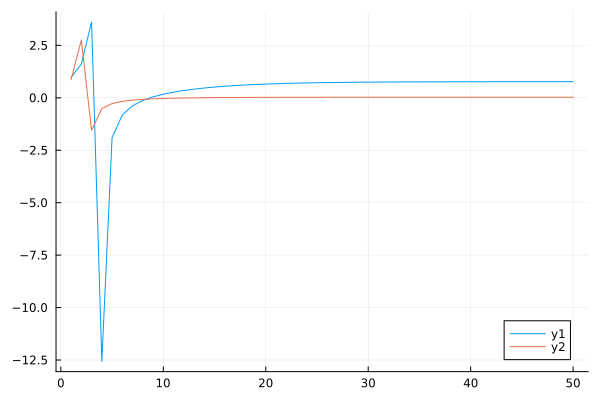

In [15]:
# Convergence des différents coeff de X
plot([x[1] for x in linear_time_iteration(rand(1,2), FO_model, deb=false).X_L][1:50])
plot!([x[2] for x in linear_time_iteration(rand(1,2), FO_model, deb=false).X_L][1:50])

In [16]:
#! X = Lim(X_n) Satisfies First Order Model ? i.e X satisfies the equation (A + BX) + (C+DX})(E+FX) = 0 ?
residual(linear_time_iteration(rand(1,2), FO_model).X,FO_model)
# Résidus << 1^{-16)

1×2 Matrix{Float64}:
 -4.44089e-16  -5.55112e-17

**Define two linear operators
`L_S(U::Union{Vector, Matrix}, X_0::Matrix, m::PerturbedModel)::Matrix`
and `L_T(U::Matrix, X_0::Matrix, m::PerturbedModel)::Matrix` which
implement the derivatives of the simulation and the time-iteration
operator respectively.**

$$\textrm{{\color{red} \underline{T does \textbf{Forward iteration}} (Time iteration operator)}}$$

$$\begin{align*} T:  \mathbb{R}^{n_x} \times \mathbb{R}^{n_s}  & \rightarrow  \mathbb{R}^{n_x} \times \mathbb{R}^{n_s}  \\ {\color{red} X_{t+1}} & \mapsto {\color{red} X_t}  \\ & \text{s.t.} \; F(X_t,X_{t+1})=0\end{align*}$$

$${\color{blue} X_{n+1} := T(X_n) \longrightarrow F(X_{n+1},X_n) = 0}$$

$$\begin{align*} T:  \mathbb{R}^{n_x} \times \mathbb{R}^{n_s}  & \rightarrow  \mathbb{R}^{n_x} \times \mathbb{R}^{n_s}  \\ {\color{red} X_{n}} & \mapsto {\color{red} X_{n+1}} \\ & \text{s.t.} \; F(X_{n+1},X_{n})=0\end{align*}$$

$$\textrm{{\color{red} \underline{P does \textbf{Backward iteration}} (Simulation operator)}}$$

$$\begin{align*} P:  \mathbb{R}^{n_s}  & \rightarrow  \mathbb{R}^{n_s}  \\ {\color{red} \Delta s_t} & \mapsto {\color{red} \Delta s_{t+1} = (E+FX)\Delta s_t} \end{align*}$$

In [19]:
#! --------------------------------------------
#! FORWARD ITERATION = Time iteration operator
#! --------------------------------------------

function T(X, M::PerturbedModel)
    (; A,B,C,D,E,F) = M
    C_DX = C+D*X    # pas efficace de calculer deux fois (C+DX)... autant stocker
    # Never compute inv(...) > rather use : solve(A,B) <> solve Ax = B <-> x = A^{-1}.B

    T = - (B+C_DX*F) \ (A+C_DX*E) #! left divide 
    # T = - solve(B+C_DX*F, A+C_DX*E) #! or solve
    # NOT OK : - inv(B + (C+D*X)*F) * (A+(C+D*X)*E) 
    
    return T
end

#! ----------------------------------------
#! BACKWARD ITERATION = Simulation operator
#! ----------------------------------------

function P(X::Matrix, s::Union{Vector,Matrix}, M::PerturbedModel) # s : state vector at date t > P(s_t) -> s_t+1
    (; A,B,C,D,E,F) = M
    P = (E+F*X)*s
    return P
end

P (generic function with 1 method)

In [20]:
#! P.s_{T-1} -> s_{T}
P(linear_time_iteration(rand(1,2), FO_model).X, [0.5 ; 0.5], FO_model)

2-element Vector{Float64}:
 0.45
 0.8482418893846204

In [22]:
#! -----------------------------------------------------------------
#!                              STABILITY : 
#! DERIVATE FUNCTIONS OF THE Simulation AND Time Iteration OPERATORS  
#! -----------------------------------------------------------------

# brutal --------------
P(X, s, M) = P(X, s, M)
T(X, M) = T(X, M)
# ---------------------

function L_T(U::Matrix, M::PerturbedModel)
    res = ForwardDiff.jacobian( u->T(u,M), U)
    return res
end

function L_P(U::Union{Vector,Matrix}, X::Union{Vector,Matrix}, M::PerturbedModel)
    res = ForwardDiff.jacobian( u->P(X,u,M), U)
    return res
end

#! On connait aussi les formes explicites de L_T et L_P ...

L_P (generic function with 1 method)

In [30]:
L_T(rand(1,2), FO_model)

2×2 Matrix{Float64}:
 0.921732  0.883183
 0.0       1.09258

In [24]:
L_P(rand(2,1), linear_time_iteration(rand(1,2), FO_model).X, FO_model)

2×2 Matrix{Float64}:
 0.9       0.0
 0.768674  0.92781

$\color{blue} \Rightarrow \textrm{Interested in the \underline{\textbf{Stability} of the Forward and Backward operators}}$

**Implement a function `spectral_radius(f::Function)::Float64` which
implements the power iteration method to compute the biggest eigenvalues
of the two previously defined operators.** 

**Check that Blanchard-Kahn
conditions are met.**

In [40]:
#! -------------------------------------------
#! POWER ITERATION METHOD - Blanchard & Kahn -
#! -------------------------------------------

L_P_spectral(s) = L_P(s, linear_time_iteration(rand(1,2), FO_model).X, FO_model)
L_T_spectral(X) = L_T(X, FO_model)

function spectral_radius(f::Function, dim::Tuple; N=500, τ_η=10^(-14))

    cvspeed_L = []
    x_0 = rand(dim...)
    u_0 = x_0 / sum(x_0.^2)
    local η

    for i in 1:N
        x_0 = f(u_0)
        u_1 = x_0 / sum(x_0.^2)
        η = sum((u_1 - u_0).^2)
        push!(cvspeed_L,η)
        u_0 = u_1
    end
    
    if η < τ_η
        return sum(x_0.^2)
    else
        return("No convergence")
    end

end

spectral_radius (generic function with 1 method)

In [43]:
L_T_spectral(rand(1,2))

2×2 Matrix{Float64}:
 0.952173  0.782429
 0.0       1.16594

In [ ]:
function Blanchard_Kahn(X,M)
    (; A,B,C,D,E,F) = M
    P = (E+F*X)
    
end

$\textrm{\textbf{{\color{blue} \underline{ We compute the spectral radius of two operators to ensure the model is well defined and that the solution is the right one}}}}$

**Write a function
`simulate(s0::Vector, X::Matrix, p, T::Int64)::Tuple{Matrix, Matrix}` to
simulate the model over $T$ periods (by using the formula
$\Delta s_t = (E + F X) \Delta s_{t-1}$.**

**Return a matrix for the states
(one line per date) and another matrix for the controls. Bonus: add a
keyword option to compute variables levels or log-deviations. If
possible, return a DataFrame object.**

------

**Warm-up: install the `ForwardDiff` library. Use it to differentiate
the function below. Check the jacobian function.**

Note: the signature of function `f` needs to be fixed first to allow for
dual numbers as arguments.

In [ ]:
test = eps(Float64)
println((1+test)-1)
println((1+test/2)-1)

# test = smallest number : a number smaller than test will disappear in computations

In [ ]:
@variables a b x

# Dual number :
# Pour redéfinir opérations 
# import Base: *
# import Base: /
# import Base: +
# import Base: -

a + b*x
Symbolics.derivative(sin(x^2), x)

In [ ]:
ForwardDiff.Dual(1.0,1.0)

In [ ]:
#function f(x::Vector{T}) where T <: Number # Is equivalent to below definition
function f(x::Vector{<:Number})
    #works because 'Dual' (number) of ForwardDiff is a Number !
    a = x[1]
    b = x[2]
    x1 = a+b
    x2 = a*exp(b)
    return [x1,x2]
end

In [ ]:
# typeof(ForwardDiff.Dual(2.0,1.0,0.0))
ForwardDiff.jacobian( u->f(u),[0.5,1.0] )